## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *

c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add PyalData folder to the path to import all modules

In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load the data

In [5]:
data_dir = "C:/Users/nerea/OneDrive/Documentos/EPFL_MASTER/PDM/Project/Code/Data"
fname = os.path.join(data_dir, "Sansa_20180507.mat")

In [6]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')

array field StimParamNames could not be converted to int.


c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


In [7]:
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data')

array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.
field idx_sent_pull could not be converted to int.
field idx_bad could not be converted to int.
field idx_decode_reach could not be converted to int.
field idx_sent_reach could not be converted to int.


The main dataframe here is trial_df, the group one will be used if needed to add some variables to the other one.

In [8]:
df = trial_df

`Note` Here not sure if there should be a combination of bins to make it longer and incude more spikes, but I will keep if as the demo, with now 20ms bins. 

#### **Combine time-bins into longer ones**

In [9]:
td = combine_time_bins(df, 2)
# now each bin corresponds to 20ms of recording.

#### **Remove low-firing neurons**

In [10]:
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

original:  (9222, 64)
removed:   (4611, 60)


c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


#### **Transform signals**

In [11]:
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
#here we change the motor and premotor cortex spikes by their square root

#### **Merge signals from multiple areas**

Signals from the pre-motor and motor cortex are now combines in one same variable, we do not consider the 2 regions as different but more as functionally working together.

In [12]:
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 60 + 64 = 124 neurons


#### **Calculate firing rates from spikes**

In [13]:
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

#### **Keep only the successful trials**

In [14]:
print("all trials:", td.shape[0])

#td = select_trials(td, "result == 'R'") --> previously this, not sure if the new "results" column is actually the "file quality"

td = select_trials(td, "file_quality == 0")

print("successful trials:", td.shape[0])

all trials: 11
successful trials: 10


In [15]:
td.head(3)

,kin_names,joint_names,bin_size,type,tonic_stim_params,reach_stim_params,pull_stim_params,stim_param_names,file_quality,idx_spike_init,...,angles,pressure,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,224,...,"[[131.3609671373651, 62.778435057557694, 129.9...","[-1.1113413890635988, -1.1154173470554491, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.223358, 0.6093754, 11.223935, 17.326077, ...","[[0.89774776, 6.201795, 22.478214, 6.412494, 5...","[[11.223358, 0.6093754, 11.223935, 17.326077, ..."
1,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 900.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,278,...,"[[129.73603167442403, 54.73211262243076, 120.8...","[-1.1155262707048532, -1.1184089790756042, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0...","[[0.6667771, 0.0031754556, 13.162496, 3.020980...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0..."
2,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1100.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,221,...,"[[127.93534095293505, 66.20842578050232, 128.3...","[-1.1130662785607814, -1.1157941240747453, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 17.063677, 0.0, 0.0, 14.686952, 6.16206...","[[0.0, 0.059919834, 2.1389797, 19.27935, 48.34...","[[0.0, 17.063677, 0.0, 0.0, 14.686952, 6.16206..."


FROM HERE WORK ON DIVIDING TRIALS BY THE DIFFERENT REACHES AND COMBINING ALL TO FEED DECODERS


In [16]:
td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)

In [17]:
td['idx_start_test'] = td.idx_reach.apply(lambda x: x[0]).astype('int64')

In [18]:
td['idx_end_test'] = td.idx_end_complete.apply(lambda x: x[0]).astype('int64')

### From here testing to create tydy data and only extract windows for the reaches in each trial

In [19]:
group_filt = group_df.loc[group_df.Quality == 0].reset_index()

In [20]:
td_all = pd.concat([td,group_filt.drop(columns = 'type')], axis = 1)

In [21]:
td_filt = td_all[['index', 'num', 'type', 'KUKAPos',
               'idx_kuka_go', 'idx_reach', 'idx_end_complete',
               'bad_indices', 'x', 'y', 'z', 'angles', 'both_spikes', 'both_rates']]


In [22]:
td_filt = td_filt.loc[td_filt.type == 'BASELINE'].reset_index()

In [23]:
td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])

In [24]:
td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])

In [25]:
td_filt

,level_0,index,num,type,KUKAPos,idx_kuka_go,idx_reach,idx_end_complete,bad_indices,x,y,z,angles,both_spikes,both_rates,test_start,test_end
0,0,0,4,BASELINE,"[3, 1, 2, 3, 1, 2]","[538, 649, 1201, 1265, 1768, 1834, 2485, 2678,...","[596, 1220, 1789, 2633, 3472]","[661, 1276, 1840, 2689, 3533]","[0, 0, 0, 0, 0]","[[-78.58536911010742, -67.11265182495117, -94....","[[157.52950286865234, 127.36316299438477, 138....","[[239.4000244140625, 213.4429702758789, 217.84...","[[131.3609671373651, 62.778435057557694, 129.9...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.223358, 0.6093754, 11.223935, 17.326077, ...",596,661
1,6,7,11,BASELINE,"[3, 1]","[536, 603, 1113, 1180]","[558, 1134]","[614, 1199]","[0, 0]","[[-71.22147750854492, 0.0, -91.54058074951172,...","[[152.43891143798828, 0.0, 138.395751953125, 1...","[[240.19979095458984, 0.0, 216.5549774169922, ...","[[133.74996637361792, 73.43466569581173, 128.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.20599091, 0.0, 0.0, 7.9226025e-05, 0....",558,614


In [26]:
win_df = split_time_fields(td_filt, start_margin = 5, end_margin = 10)

`Note`angle 3 is better to visualize X data and angle 4 for Y data.

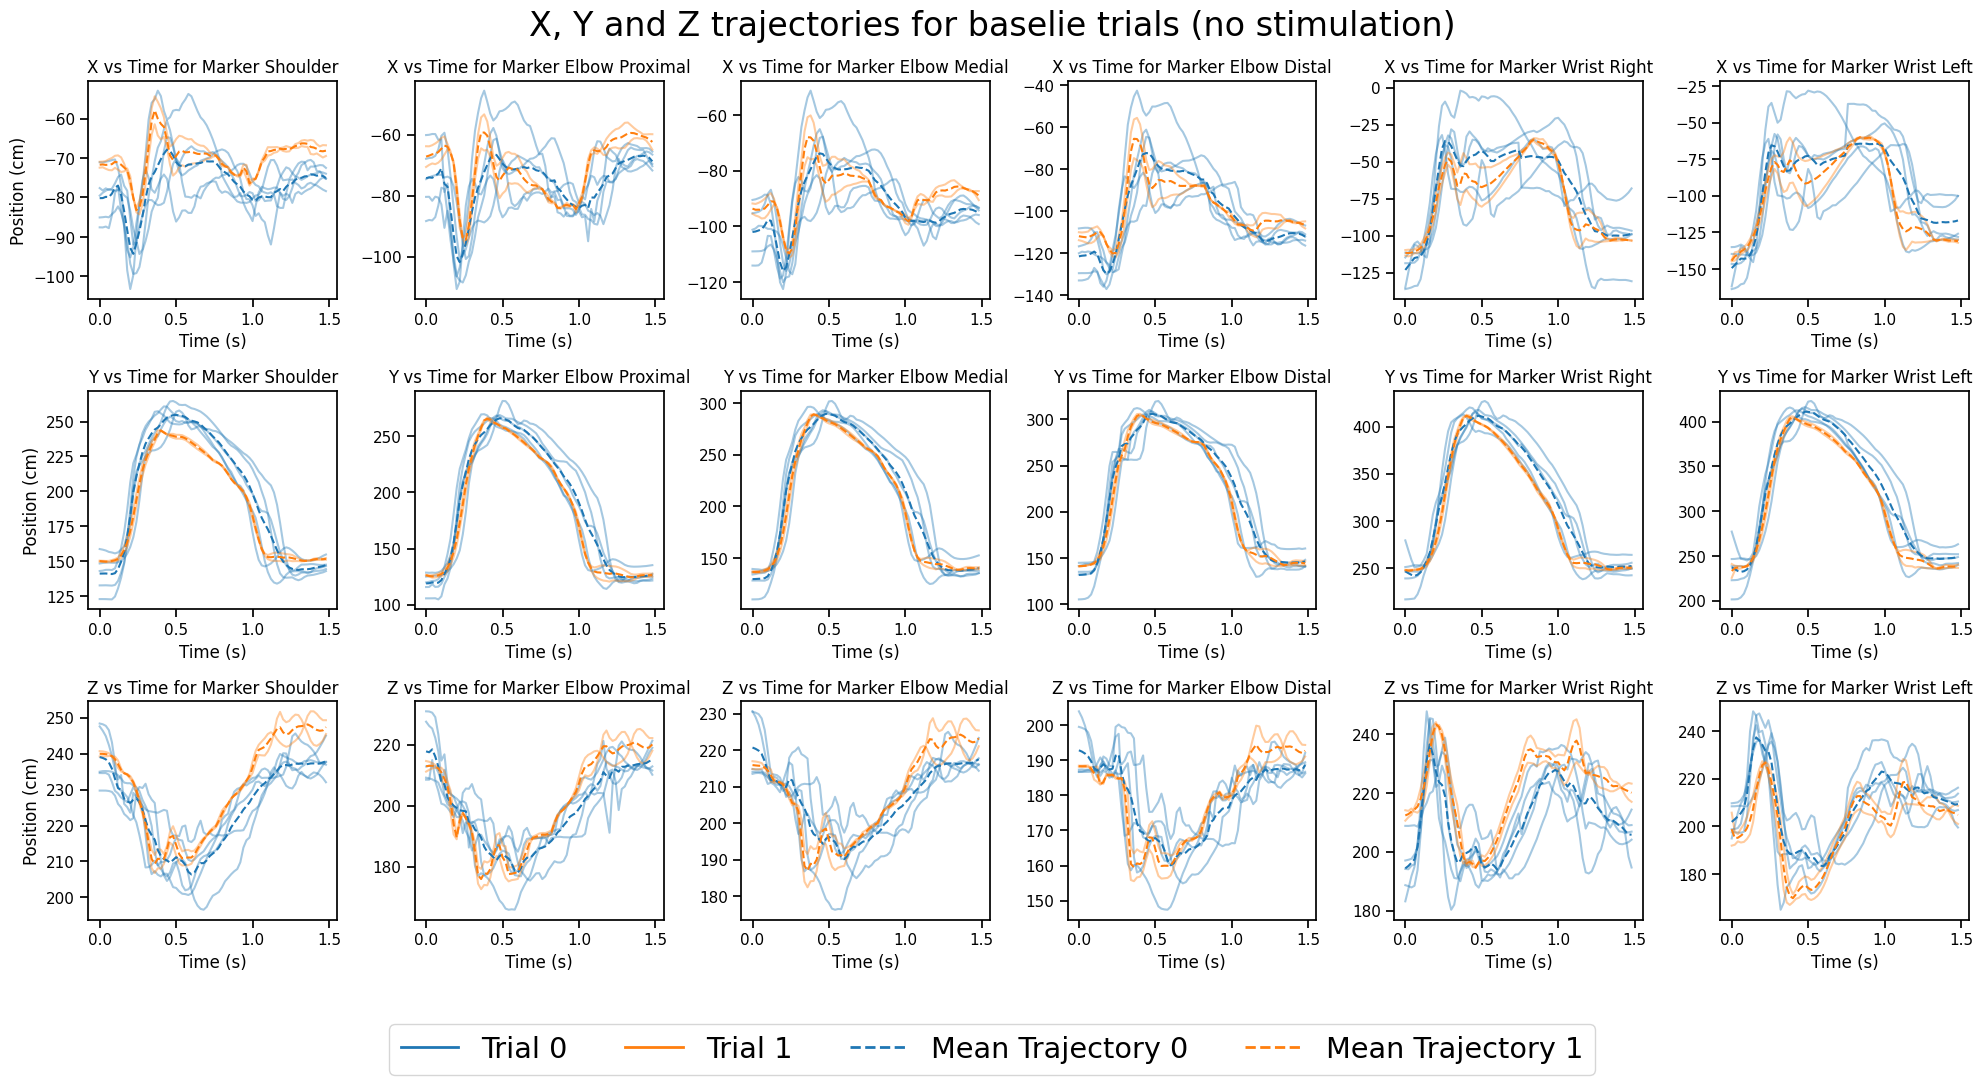

In [27]:
# Visualize the trajectories, split by reach trial
visualize_traj(win_df, ['x', 'y', 'z'], marker_names = ['Shoulder',	'Elbow Proximal',	'Elbow Medial',	'Elbow Distal',	'Wrist Right',	'Wrist Left'])  # Replace df with your actual DataFrame containing trajectory data


In [28]:
win_df['angles'] = np.nan_to_num(win_df['angles'], nan = 0)

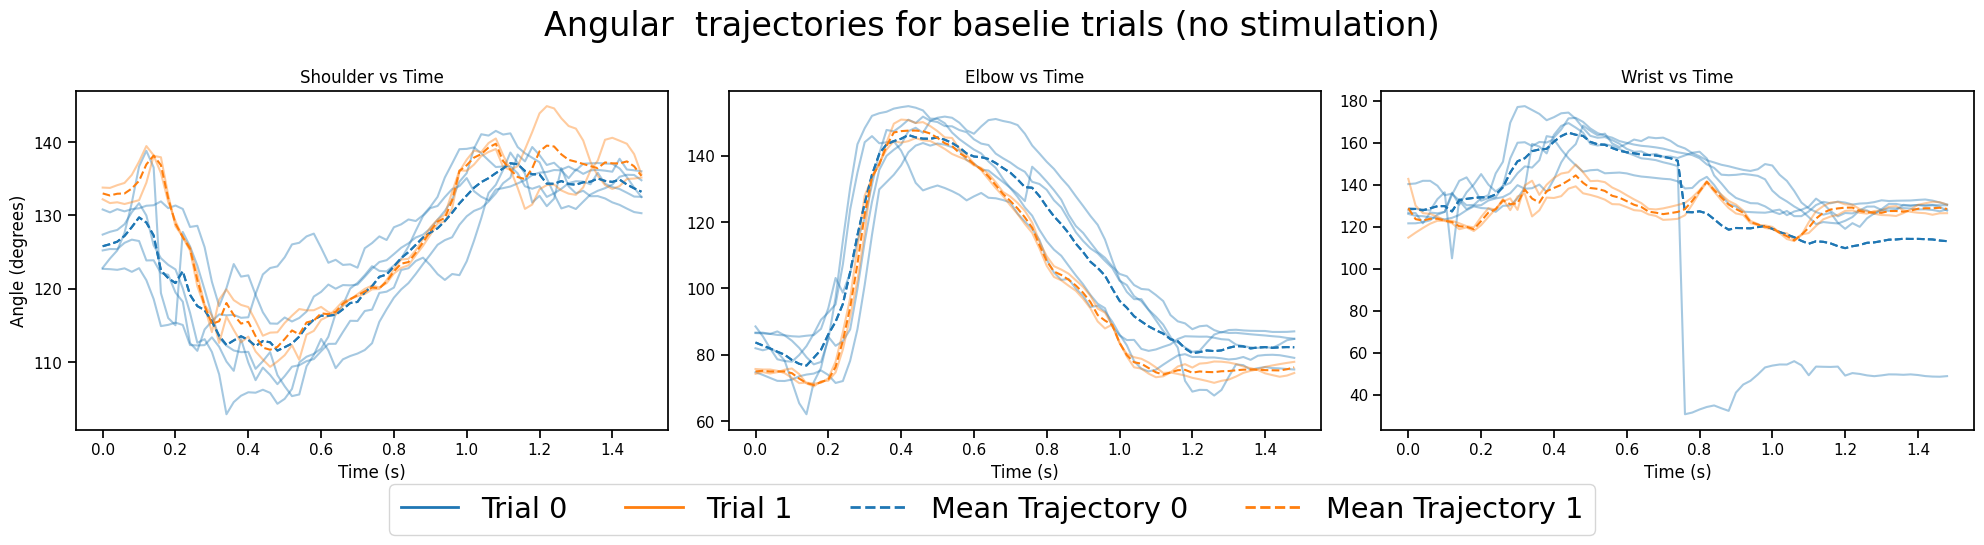

In [29]:
visualize_angles(win_df, 'angles',  angle_names = ['Shoulder', 'Elbow', 'Wrist'])

In [30]:
tidy_df = build_tidy_df(td_filt, start_margin = 5)

In [31]:
tidy_df.head()

,num,type,KUKAPos,trial_num,reach_num,time_sample,x,y,z,angles,both_spikes,both_rates
0,4,BASELINE,3,0,0,0,"[-77.6164779663086, -67.95040130615234, -95.28...","[158.6729965209961, 128.56824493408203, 139.27...","[247.58300018310547, 227.59004974365234, 230.6...","[122.84298568482022, 81.93446516090057, 140.33...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0.032221857, 2.218497, 8.058753, 8.058753, 21..."
1,4,BASELINE,3,0,0,1,"[-78.22501373291016, -67.70167541503906, -95.0...","[158.23117065429688, 128.38842010498047, 139.0...","[246.39349365234375, 226.2129898071289, 229.09...","[124.11316773733145, 81.3188549818272, 140.628...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.4142135623730951, ...","[0.070607685, 3.884301, 7.4482527, 7.4482527, ..."
2,4,BASELINE,3,0,0,2,"[-77.68076705932617, -67.57518768310547, -94.7...","[157.60812377929688, 128.55951690673828, 138.8...","[244.88976287841797, 225.34695434570312, 226.9...","[125.21543173100524, 81.91241905463124, 141.89...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.414...","[0.22446097, 5.7970095, 6.0209713, 6.0209713, ..."
3,4,BASELINE,3,0,0,3,"[-78.0939712524414, -66.99567413330078, -94.02...","[156.6243133544922, 128.30847930908203, 138.36...","[242.42359161376953, 222.2879409790039, 223.75...","[127.61107512204953, 80.75976099668813, 141.88...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.63357174, 7.380321, 4.5177937, 4.5177937, 3..."
4,4,BASELINE,3,0,0,4,"[-77.77334976196289, -64.91877174377441, -91.8...","[156.21121978759766, 128.82231903076172, 138.7...","[239.40994262695312, 217.74452209472656, 219.4...","[131.72727044231465, 78.21253895029551, 139.54...","[0.0, 1.0, 0.0, 0.0, 1.7320508075688772, 1.414...","[1.527674, 8.03877, 3.746171, 3.746171, 49.112..."


#### **Further preprocess by subtracting cross-condition mean**

In [32]:
# aka center per time point
move_td = subtract_cross_condition_mean(tidy_df) # --> maybe not needed here, I'll still standardize data later

In [33]:
tidy_df['id'] = tidy_df['trial_num'].astype(str) + '_' + tidy_df['reach_num'].astype(str)

We now want to split this data into training-validation-test by doing:

- split by reach_number 
- maximum amount of trial numbers represented in the validation/test data 
- homogeneous distribution of the KUKAPos is possible (changes the trajectory, so that the model does not learn only 1 specific trajectory) 
- Here the type is always BASELINE, as it is the first model, then we will decide if we train also using BC-PULL data or we only test on that.

Now the next question is "What do we want to predict exactly?"

Options:

- Predict only x or y vector with all markers.
- Predict a vector combining all markers for all directions.
- Create an additional variable, combining all the previous information.
- Predict the angles instead of the marker positions.


For the first model let's say we use only "both_rates" as X matrix and "x" position (including all markers) as target (or y). 

In [34]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(tidy_df, target_variable = 'y', num_folds = 5)

fold 0  train_ids  ['0_1', '0_3', '0_4', '0_2', '1_1']
fold 0  val_ids  ['0_0']
fold 0  test_ids  ['1_0']
fold 1  train_ids  ['0_2', '1_0', '0_4', '1_1', '0_1']
fold 1  val_ids  ['0_0']
fold 1  test_ids  ['0_3']
fold 2  train_ids  ['1_1', '0_4', '0_1', '1_0', '0_0']
fold 2  val_ids  ['0_3']
fold 2  test_ids  ['0_2']
fold 3  train_ids  ['0_1', '0_3', '1_1', '1_0', '0_2']
fold 3  val_ids  ['0_4']
fold 3  test_ids  ['0_0']
fold 4  train_ids  ['0_0', '1_0', '0_4', '0_3', '0_1']
fold 4  val_ids  ['1_1']
fold 4  test_ids  ['0_2']


In [35]:
from collections import Counter

def calculate_mode(data):
    """
    Calculate the mode of a dataset.

    Args:
    - data (list or numpy array): The input dataset.

    Returns:
    - mode: The mode(s) of the dataset.
    """
    # Use Counter to count occurrences of each value
    data = np.round(data, 3)
    counts = Counter(data)

    # Get the maximum count
    max_count = max(counts.values())

    # Find all values with the maximum count (could be multiple modes)
    modes = [value for value, count in counts.items() if count == max_count]

    return modes


Here we want to analyse the target distribution.
We will use fold 0 as an example, as we expect the rest to be similar.

In [36]:
y_test_dist = y_test['fold0']

0  mean  0.42177155787152476  median  0.42613403761695223  mode  [0.009]  std dev  0.3852178197152332
1  mean  0.4215027215848488  median  0.42654124484169664  mode  [0.003]  std dev  0.3774931204795682
2  mean  0.4342287019229631  median  0.43967650139481795  mode  [0.0, 0.019, 0.037, 0.035]  std dev  0.38189559762748376
3  mean  0.4537072117138165  median  0.5192530413378962  mode  [0.001]  std dev  0.39046285056007624
4  mean  0.38889977627802946  median  0.33673788352765405  mode  [0.009]  std dev  0.3679518251778645
5  mean  0.43073932676990806  median  0.44620562802734587  mode  [0.016]  std dev  0.3828372044039963


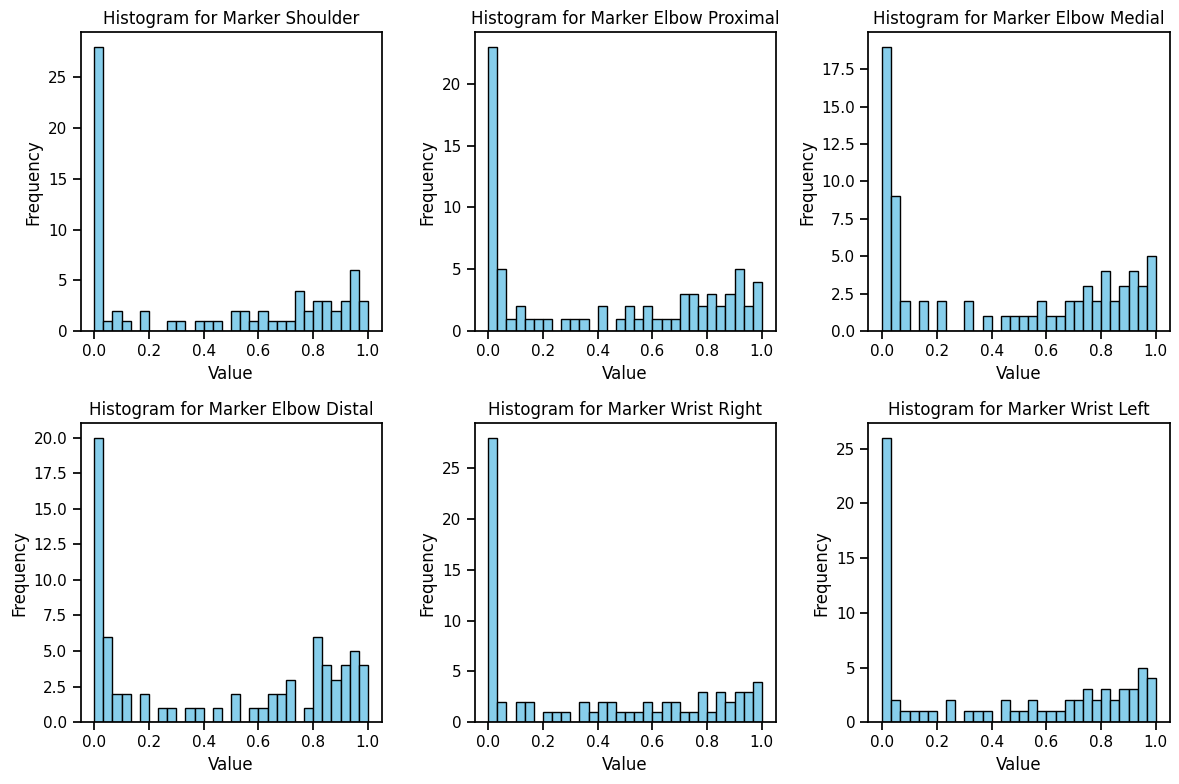

In [37]:
# Get the number of markers (features)
num_markers = y_test_dist.shape[1]

# Plot histograms for each marker
plt.figure(figsize=(12, 8))
marker_names =  ['Shoulder',	'Elbow Proximal',	'Elbow Medial',	'Elbow Distal',	'Wrist Right',	'Wrist Left']
for i in range(num_markers):
    plt.subplot(2, 3, i+1)  # Adjust the subplot layout as needed
    plt.hist(y_test_dist[:, i], bins=30, color='skyblue', edgecolor='black')
    print(i, ' mean ', np.mean(y_test_dist[:,i]), ' median ', np.median(y_test_dist[:,i]), ' mode ', calculate_mode(y_test_dist[:,i]), ' std dev ', np.std(y_test_dist[:,i]))
    #skewness, and kurtosis
    plt.title(f'Histogram for Marker {marker_names[i]}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Explanation of what function to use as activation for my LSTM based on the data description and analysis:

If your output represents a 0-1 distribution that is left-skewed but gradually increases towards the right, you would typically want to use an activation function that can handle bounded outputs and is capable of capturing non-linear relationships. In this scenario, the best choice of activation function after the second linear layer could be the **sigmoid activation function**.

The sigmoid function has the following properties:

- *Bounded Output*: The output of the sigmoid function is bounded between 0 and 1, which aligns with your distribution.

- *Non-linearity*: The sigmoid function introduces non-linearity to the model, allowing it to capture complex relationships between features and outputs.

- *Smooth Gradient*: The sigmoid function has a smooth gradient, which facilitates stable training via backpropagation.

## Ridge Regression

In [38]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, FactorAnalysis

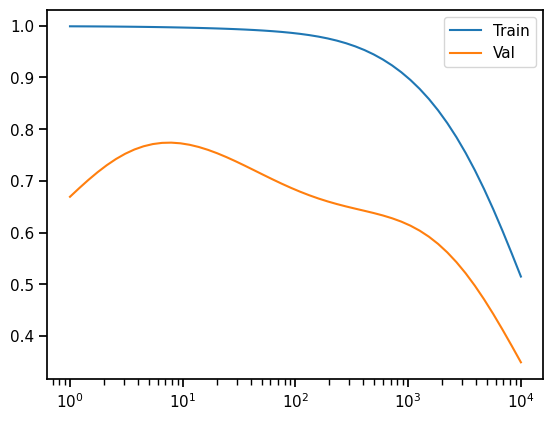

In [39]:
num_folds = 5
dim_reduce = False
num_dim = 10

alphas = np.logspace(0, 4, 50)

test_score = []
train_score = []
best_a = []

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None

    for a in alphas:
        if dim_reduce == True:

            PCA_model = PCA(num_dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])
        else:
            X_train_ = X_train['fold'+str(i)]
            X_val_ = X_val['fold'+str(i)]
            X_test_ = X_test['fold'+str(i)]

        model = Ridge(alpha = a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
    if i == 3:
        plt.plot(alphas, train_score_a, label = 'Train')
        plt.plot(alphas, val_score_a, label = 'Val')
        plt.xscale('log')
        plt.legend()

    best_a.append(alphas[np.argmax(val_score_a)])
    test_score.append(best_model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(best_model.score(X_train_, y_train['fold'+str(i)]))


In [40]:
best_a

[193.06977288832496,
 159.98587196060572,
 109.85411419875584,
 7.906043210907698,
 62.505519252739695]

In [41]:
train_score

[0.9710888284712339,
 0.9788159818257748,
 0.9865018190329286,
 0.9969918149152925,
 0.9895122830681995]

In [42]:
test_score

[0.819832616250472,
 0.7564589804128312,
 0.7164225711536352,
 0.6551686448147748,
 0.7717844098711142]

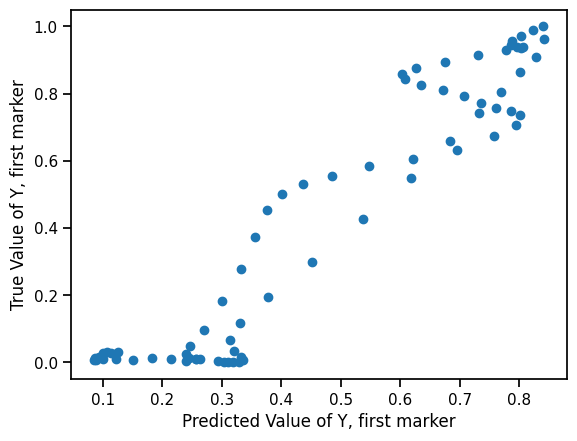

In [43]:
from itertools import product

num_folds = 5
dim_reduce = True
num_dim = 10

alphas = np.logspace(-4, 3, 50)
pca_dimensions = np.arange(5,50,10)  # Define the PCA dimensions to search over

test_score = []
train_score = []
best_a_list = []
best_dim_list = []

# Define the grid of parameters to search over
param_grid = list(product(alphas, pca_dimensions))

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None
    best_a = 0
    best_dim = 5

    for a, dim in param_grid:
        if dim_reduce == True:
            PCA_model = PCA(dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])


        model = Ridge(alpha=a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
            best_a = a  # Update best alpha
            best_dim = dim  # Update best PCA dimension

    best_a_list.append(best_a)
    best_dim_list.append(best_dim)
    PCA_model = PCA(best_dim).fit(X_train['fold'+str(i)])
    X_train_ = PCA_model.transform(X_train['fold'+str(i)])
    X_val_ = PCA_model.transform(X_val['fold'+str(i)])
    X_test_ = PCA_model.transform(X_test['fold'+str(i)])
    model = Ridge(alpha=best_a, fit_intercept=True)
    model.fit(X_train_, y_train['fold'+str(i)])
    test_score.append(model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(model.score(X_train_, y_train['fold'+str(i)]))
    if i == 0:
        plt.scatter(model.predict(X_test_)[:,0], y_test['fold'+str(i)][:,0])
        plt.ylabel('True Value of Y, first marker')
        plt.xlabel('Predicted Value of Y, first marker')


In [44]:
best_a_list

[37.27593720314938, 0.0001, 0.0001, 0.0001, 0.0001]

In [45]:
best_dim_list

[45, 45, 45, 5, 45]

In [46]:
test_score

[0.8419593105049344,
 0.7282293991330714,
 0.681546818958617,
 0.5193402831639478,
 0.7675852726088781]

In [47]:
train_score

[0.978414406375565,
 0.9823184106150918,
 0.9867614858815124,
 0.7885660785780083,
 0.9811078940947594]

## LSTM

In [48]:
X_train = X_train['fold0']
X_val = X_val['fold0']
X_test = X_test['fold0']

In [49]:
y_test = y_test['fold0']
y_train = y_train['fold0']
y_val = y_val['fold0']

In [50]:
len(y_val)

75

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

In [52]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
# to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
# to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
# from_t = lambda tensor: tensor.to("cpu").detach().numpy()

path_to_data = './Data'
#path_to_json_exp = './'
path_to_models = './Models'


In [53]:
class CausalTemporalLSTM(nn.Module):
    def __init__(self, num_features=124, 
                    hidden_units= 3, #was 128
                    #initial_offset = -2,
                    num_layers = 2, 
                    out_dims = 6):
        super(CausalTemporalLSTM, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size= int(num_features/4),
            hidden_size=hidden_units,
            batch_first=True,
            num_layers= num_layers,
            bidirectional=False,
        )
        self.linear1 = nn.Linear(in_features=self.num_features, out_features=int(num_features/4))
        self.linear2 = nn.Linear(in_features=self.hidden_units, out_features=out_dims)

    def forward(self, x):

        x = self.linear1(x)
        x, _ = self.lstm(x)
        output = self.linear2(x)
        # Apply sigmoid activation function
        output = torch.sigmoid(output)
        
        return output.squeeze()

In [54]:
def Regularizer_LSTM(model, alpha=1e-5, l1_ratio=0.5):
    """
    Implement an L1-L2 penalty on the norm of the model weights.

    model: CausalTemporalLSTM instance
    alpha: scaling parameter for the regularization.
    l1_ratio: mixing parameter between L1 and L2 loss.

    Returns:
    reg: regularization term
    """
    w_t = model.lstm.weight_ih_l0
    w_l = model.linear.weight
    w_l_1 = model.linear1.weight

    l1_loss = w_t.abs().sum() + w_l.abs().sum() + w_l_1.abs().sum()
    l2_loss = w_t.pow(2.0).sum() + w_l.pow(2.0).sum() + w_l_1.pow(2.0).sum()

    reg = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg = alpha * reg

    return reg.item()

In [55]:
class SequenceDataset(Dataset):

    def __init__(self, y, X, sequence_length=10):
        """
        Initializes the SequenceDataset.
        
        Args:
            y (torch.Tensor): The target labels for each sequence.
            X (torch.Tensor): The input sequences.
            sequence_length (int): The desired length of each sequence.
        """
        self.sequence_length = sequence_length
        self.y = torch.tensor(y)
        self.X = torch.tensor(X)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return self.X.shape[0] * self.X.shape[1]

    def __getitem__(self, i): 
        """
        Gets the i-th sample from the dataset.
        
        Args:
            i (int): Index of the desired sample.
        
        Returns:
            xx (torch.Tensor): Input sequence of length sequence_length.
            yy (torch.Tensor): Corresponding target sequence.
        """
        trial_index = i // self.X.shape[1]
        point_index = i % self.X.shape[1]
        
        if point_index > self.sequence_length - 1:
            point_start = point_index - self.sequence_length
            xx = self.X[trial_index, point_start:point_index, :]
            yy = self.y[trial_index, point_start+1:point_index+1, :]
        else:
            padding_x = self.X[trial_index, 0:1, :].repeat(self.sequence_length - point_index, 1)
            padding_y = self.y[trial_index, 0:1, :].repeat(self.sequence_length - point_index - 1, 1)
            xx = self.X[trial_index, 0:point_index, :]
            xx = torch.cat((padding_x, xx), dim=0)
            yy = self.y[trial_index, 0:point_index + 1, :]
            yy = torch.cat((padding_y, yy), dim=0)
            
        return xx, yy
    
    


In [56]:
def train_model(model, 
                X,
                Y,
                X_val, 
                Y_val,
                objective,
                regularizer=None,
                num_epochs=1000, 
                lr=0.0001,
                early_stop = 5,
                lr_step_size=10,
                batch_size_train = 3,
                batch_size_val = 3,
                lr_gamma=0.9):

    # Set up the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset = SequenceDataset(
    Y,    X,    sequence_length=10)

    val_dataset = SequenceDataset(
    Y_val,    X_val,    sequence_length=10)
    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loader = loader_train
            else:
                model.eval()
                loader = loader_val

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for X_, y_ in loader:
                #X_ = X_.to('cuda')
                #y_ = y_.to('cuda')
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        output_t = model(X_)
                        output_t = torch.squeeze(output_t)


                        loss_t = objective(output_t, y_)
                        
                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            loss_t += regularizer
                        # Compute gradients and perform an optimization step
                        loss_t.backward()
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    output_t = model(X_)
                    output_t = torch.squeeze(output_t)

                    loss_t = objective(output_t, y_)

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses)

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

In [57]:
def mean_squared_loss(y_true, y_pred):
    """
    Calculate the Mean Squared Error (MSE) between two tensors.
    
    Args:
    - y_true: Tensor containing the true values (ground truth).
    - y_pred: Tensor containing the predicted values.
    
    Returns:
    - mse: Mean Squared Error between y_true and y_pred.
    """
    # Ensure both tensors have the same shape
    assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must match"

    # Calculate squared differences between true and predicted values
    squared_errors = (y_true - y_pred)**2

    # Calculate the mean of squared errors
    mse = torch.mean(squared_errors)

    return mse

In [58]:


seq_length_LSTM = 10
#X, Y = create_dataset(X, Y, lookback=seq_length)
#X_val, Y_val = create_dataset(X_val, Y_val, lookback=seq_length_LSTM)
reshape_input = True
batch_size_train= 25 # It was 2048, but here we have only 375 samples 
batch_size_val= 25 # it was 1024, but here we have only 75 samples 
num_epochs = 1000
fold = 1
num_dim_output = 6

seq_length = 75 #samples per reach trial.

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

In [61]:
seed = 42
torch.manual_seed(seed)

learning_rate = 0.001
Loss_function = mean_squared_loss

Loss_function = globals().get(mean_squared_loss)
Reg = globals().get(Regularizer_LSTM)

In [62]:
# Fit the LSTM model
model = CausalTemporalLSTM(num_features=124, 
                hidden_units= 2, #was 128
                #initial_offset = -2,
                num_layers = 3, # it was 1
                out_dims = 6).to(device)
train_losses, val_losses = \
    train_model(model, 
                xx_train, 
                yy_train,
                xx_val, 
                yy_val,
                mean_squared_loss, 
                regularizer=Reg, #1e-5
                lr= learning_rate, 
                num_epochs=num_epochs, 
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                lr_gamma=0.9) 

Epoch 000 Train 0.1212 Val 0.1341
Epoch 001 Train 0.1203 Val 0.1333
Epoch 002 Train 0.1195 Val 0.1325
Epoch 003 Train 0.1185 Val 0.1315
Epoch 004 Train 0.1173 Val 0.1303
Epoch 005 Train 0.1158 Val 0.1286
Epoch 006 Train 0.1137 Val 0.1264
Epoch 007 Train 0.1112 Val 0.1237
Epoch 008 Train 0.1081 Val 0.1203
Epoch 009 Train 0.1045 Val 0.1169
Epoch 010 Train 0.1004 Val 0.1126
Epoch 011 Train 0.0962 Val 0.1085
Epoch 012 Train 0.0918 Val 0.1039
Epoch 013 Train 0.0873 Val 0.0994
Epoch 014 Train 0.0831 Val 0.0954
Epoch 015 Train 0.0790 Val 0.0938
Epoch 016 Train 0.0754 Val 0.0866
Epoch 017 Train 0.0719 Val 0.0841
Epoch 018 Train 0.0686 Val 0.0799
Epoch 019 Train 0.0655 Val 0.0770
Epoch 020 Train 0.0627 Val 0.0742
Epoch 021 Train 0.0603 Val 0.0716
Epoch 022 Train 0.0579 Val 0.0700
Epoch 023 Train 0.0557 Val 0.0670
Epoch 024 Train 0.0535 Val 0.0649
Epoch 025 Train 0.0515 Val 0.0630
Epoch 026 Train 0.0496 Val 0.0603
Epoch 027 Train 0.0478 Val 0.0586
Epoch 028 Train 0.0460 Val 0.0568
Epoch 029 Trai

NEXT:
- PREPARE PRESENTATION
- PREPARE TEMPLATE FROM LATEX WITH THE INTRO, DATA EXPLANATION, BASELINE MODELS...


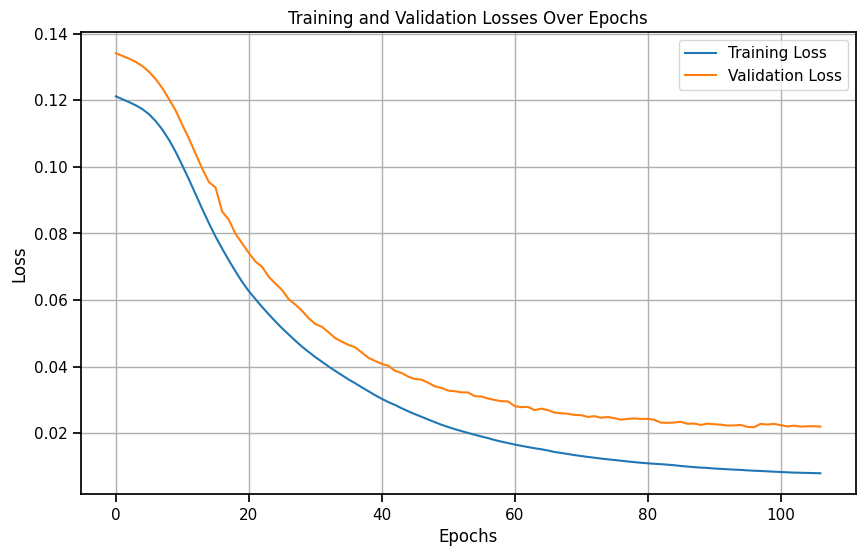

In [63]:
def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses over epochs.

    Args:
    - train_losses (numpy array): Array containing training losses for each epoch.
    - val_losses (numpy array): Array containing validation losses for each epoch.
    """
    epochs = len(train_losses)
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)